# Evaluation

## Evaluation First Round Sent-Similarity vs NSP (BM25 Ranking)

In [31]:
import pandas as pd
from sklearn.metrics import ndcg_score, precision_score
import numpy as np
import math

In [74]:
colnames = ['id', 'R_N', 'R_I', 'R_P', 'S_N', 'S_I', 'S_P', 'sent_pair']
df = pd.read_csv('data/evaluation/eval_sent_sim_last_year_topics - eval_sent_sim_last_year_topics.csv', names=colnames).drop(columns=['id', 'S_N', 'S_I', 'S_P'])

In [43]:
df = df.iloc[2:]

In [97]:
def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

def clean_list(evaluation_list: list) -> list[int]:
    return [int(value) for value in evaluation_list if value == value]

def precision(relevance_list: list[int]) -> float:
    relevant_results = [score for score in relevance_list if score > 0]
    return len(relevant_results)/len(relevance_list)


def calc_precision_scores(relevance_list: list[int], n_topics: int) -> float:
    precision_scores = []
    start = 1
    for i in range(n_topics):
        topic_relevance_list = [int(s) if int(s) >= 0 else 0 for s in relevance_list[start:start + 10]]
        relevant_results = [score for score in topic_relevance_list if score > 0]
        precision_scores.append(round_half_up(len(relevant_results)/len(topic_relevance_list), decimals=3))
        start += 12
    return precision_scores

def calc_ndcg_scores(relevance_list: list[int], n_topics: int) -> float:
    ndcg_scores = []
    start = 1
    for i in range(n_topics):
        topic_relevance_list = [int(s) if int(s) >= 0 else 0 for s in relevance_list[start:start + 10]]
        scores = np.asarray([topic_relevance_list])
        true_relevance = np.asarray([sorted(topic_relevance_list,reverse=True)])
        ndcg_scores.append(round_half_up(ndcg_score(true_relevance, scores), decimals=3))
        start += 12
    return ndcg_scores

def mean_sent_pair_len(path):
    print(path)
    colnames = ['relevance', 'output']
    df = pd.read_csv(path, usecols=colnames)
    mean_sent_pair_len = round_half_up(df[df['output'].notna()]['output'].apply(len).mean(), decimals=3)
    print(f'Mean Len: {round_half_up(np.mean(mean_sent_pair_len), decimals=3)}\n')
    return mean_sent_pair_len

Count length of sent pairs

In [96]:
baseline_bm25_sent_sim = mean_sent_pair_len("data/evaluation/eval_sent_sim_last_year_topics - eval_sent_sim_last_year_topics.csv")
baseline_bm25_nsp = mean_sent_pair_len("data/evaluation/eval_nsp_last_year_topics - eval_nsp_last_year_topics.csv")
baseline_bm25_nsp_acl_bert = mean_sent_pair_len("data/evaluation/eval_nsp_qbf_last_year_topics - eval_nsp_qbf_last_year_topics.csv")
mean_len_bm25 = [baseline_bm25_sent_sim, baseline_bm25_nsp, baseline_bm25_nsp_acl_bert]
print(f'Average Sentence Length of pipeline with BM25 Ranking Component: {np.mean(mean_len_bm25)}')

data/evaluation/eval_sent_sim_last_year_topics - eval_sent_sim_last_year_topics.csv
Mean Len: 137.902

data/evaluation/eval_nsp_last_year_topics - eval_nsp_last_year_topics.csv
Mean Len: 168.665

data/evaluation/eval_nsp_qbf_last_year_topics - eval_nsp_qbf_last_year_topics.csv
Mean Len: 188.896

Average Sentence Length of pipeline with BM25 Ranking Component: 165.1543333333333


In [37]:
relevance_nils = df['R_N'].tolist()
relevance_istvan = df['R_I'].tolist()
relevance_pia = df['R_P'].tolist()

relevance_nsp = clean_list(relevance_pia)[:50] + clean_list(relevance_istvan)[50:]

In [38]:
print(precision(clean_list(relevance_nils)), precision(clean_list(relevance_istvan)), precision(clean_list(relevance_pia)))

0.28 0.39 0.35


In [39]:
print(precision(relevance_nsp))

0.34


In [46]:
def create_relevance_buckets(relevance_list: list[int]) -> list[int]:
    spam = [score for score in relevance_list if score < 0]
    non_relevant = [score for score in relevance_list if score == 0]
    one_relevant = [score for score in relevance_list if score == 1]
    two_relevant = [score for score in relevance_list if score == 2]
    three_relevant = [score for score in relevance_list if score == 3]

    return [len(spam), len(non_relevant), len(one_relevant), len(two_relevant), len(three_relevant)]


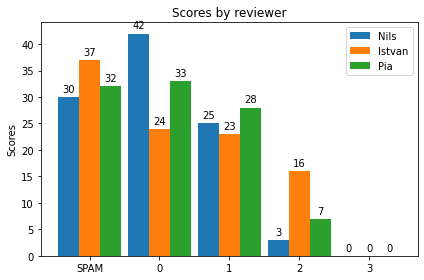

In [47]:
import matplotlib.pyplot as plt
labels = ['SPAM', '0', '1', '2', '3']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rect_nils = ax.bar(x - width, create_relevance_buckets(clean_list(relevance_nils)), width, label='Nils')
rect_istvan = ax.bar(x, create_relevance_buckets(clean_list(relevance_istvan)), width, label='Istvan')
rect_pia = ax.bar(x + width, create_relevance_buckets(clean_list(relevance_pia)), width, label='Pia')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by reviewer')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rect_nils, padding=3)
ax.bar_label(rect_istvan, padding=3)
ax.bar_label(rect_pia, padding=3)

fig.tight_layout()

plt.savefig('plots/scores_by_reviewer.jpg')

plt.show()


### DirichletLM with SVM

In [48]:
colnames = ['relevance', 'output']
df = pd.read_csv('data/evaluation/porthos_svm_lm_basic - porthos_svm_lm_basic.csv', usecols=colnames)

In [49]:
df = df.reset_index().drop(['index'], axis=1)

In [50]:
relevance = df['relevance'].tolist()

In [51]:
precision(clean_list(relevance))

0.36

In [54]:
relevance_list = df['relevance'].tolist()
calc_ndcg_score(relevance_list, n_topics=10)

NameError: name 'calc_ndcg_score' is not defined

### Preprocessed with ACL DirichletLM

In [55]:
def eval_scoring(path:str):
    print(path)
    colnames = ['relevance', 'output']
    n_topics = 10
    hits = 10
    df = pd.read_csv(path, usecols=colnames)
    df = df.reset_index().drop(['index'], axis=1)
    relevance = df['relevance'].tolist()
    ndgc_scores = calc_ndcg_scores(relevance, n_topics=n_topics)
    precision_scores = calc_precision_scores(relevance, n_topics=n_topics)

    print(f'Topic \t Precision@{hits}  \t nDCG@{hits}')

    for i in range(n_topics):
        print(f'{i+1} \t {precision_scores[i]} \t \t {ndgc_scores[i]}')



    print(f'\nPrecision: {round_half_up(np.mean(precision_scores), decimals=3)}')
    print(f'NDCG: {round_half_up(np.mean(ndgc_scores), decimals=3)}\n')
    
    return precision_scores, ndgc_scores

In [56]:
w_conclusion_diriciletlm_precision, w_conclusion_diriciletlm_ndcg = eval_scoring("data/evaluation/porthos_lm_analyzed_w_conclusion - porthos_lm_analyzed_w_conclusion.csv")

data/evaluation/porthos_lm_analyzed_w_conclusion - porthos_lm_analyzed_w_conclusion.csv
Topic 	 Precision@10  	 nDCG@10
1 	 0.4 	 	 0.505
2 	 1.0 	 	 0.783
3 	 0.2 	 	 0.446
4 	 0.3 	 	 0.75
5 	 1.0 	 	 0.905
6 	 0.2 	 	 0.446
7 	 0.6 	 	 0.708
8 	 0.6 	 	 0.582
9 	 0.5 	 	 0.778
10 	 0.0 	 	 0.0

Precision: 0.48
NDCG: 0.59



In [57]:
np.mean([0.724, 0.947, 0.769, 0.899, 0.942, 0.415, 0.917, 0.879, 0.913, 0])

0.7405

### Calclate Pricision@10 and nDCG@10 Scores for several approaches

In [59]:
acl_diriciletlm_precision, acl_diriciletlm_ndcg = eval_scoring("data/evaluation/porthos_acl_lm_basic - porthos_acl_lm_basic.csv")
acl_diriciletlm_acl_precision, acl_diriciletlm_acl_ndcg = eval_scoring("data/evaluation/porthos_acl_lm_basic_acl - porthos_acl_lm_basic_acl.csv")
w_conclusion_diriciletlm_precision, w_conclusion_diriciletlm_ndcg = eval_scoring("data/evaluation/porthos_lm_analyzed_w_conclusion - porthos_lm_analyzed_w_conclusion.csv")
svm_diricilet_precision, svm_diricilet_ndcg = eval_scoring("data/evaluation/porthos_svm_lm_basic - porthos_svm_lm_basic.csv")
bm25_qbf_precision, bm25_qbf_ndcg = eval_scoring("data/evaluation/eval_nsp_qbf_last_year_topics - eval_nsp_qbf_last_year_topics.csv")
premise_conc_dml_noun_boosting_precision, premise_conc_dml_noun_boosting_ndcg = eval_scoring("data/evaluation/porthos_premises_and_conclusions_lm_analyzer_query_improved - porthos_premises_and_conclusions_lm_analyzer_query_improved.csv")
premise_conc_dml_noun_boosting_acl_precision, premise_conc_dml_noun_boosting_acl_ndcg = eval_scoring("data/evaluation/porthos_premises_and_conclusions_lm_analyzer_query_improved_acl - porthos_premises_and_conclusions_lm_analyzer_query_improved_acl.csv")

data/evaluation/porthos_acl_lm_basic - porthos_acl_lm_basic.csv
Topic 	 Precision@10  	 nDCG@10
1 	 0.4 	 	 0.503
2 	 0.9 	 	 0.795
3 	 0.2 	 	 0.446
4 	 0.2 	 	 0.927
5 	 0.9 	 	 0.856
6 	 0.2 	 	 0.927
7 	 0.9 	 	 0.821
8 	 0.2 	 	 0.415
9 	 0.0 	 	 0.0
10 	 0.0 	 	 0.0

Precision: 0.39
NDCG: 0.569

data/evaluation/porthos_acl_lm_basic_acl - porthos_acl_lm_basic_acl.csv
Topic 	 Precision@10  	 nDCG@10
1 	 0.2 	 	 0.446
2 	 0.8 	 	 0.807
3 	 0.1 	 	 0.394
4 	 0.2 	 	 0.86
5 	 1.0 	 	 0.92
6 	 0.2 	 	 0.899
7 	 1.0 	 	 0.788
8 	 0.2 	 	 0.446
9 	 0.5 	 	 0.612
10 	 0.0 	 	 0.0

Precision: 0.42
NDCG: 0.617

data/evaluation/porthos_lm_analyzed_w_conclusion - porthos_lm_analyzed_w_conclusion.csv
Topic 	 Precision@10  	 nDCG@10
1 	 0.4 	 	 0.505
2 	 1.0 	 	 0.783
3 	 0.2 	 	 0.446
4 	 0.3 	 	 0.75
5 	 1.0 	 	 0.905
6 	 0.2 	 	 0.446
7 	 0.6 	 	 0.708
8 	 0.6 	 	 0.582
9 	 0.5 	 	 0.778
10 	 0.0 	 	 0.0

Precision: 0.48
NDCG: 0.59

data/evaluation/porthos_svm_lm_basic - porthos_svm_lm_basic

### Calculate mean length of returned sentence pairs in BM25 and DirichletLM

In [62]:
colnames = ['relevance', 'output']
df = pd.read_csv('data/evaluation/eval_nsp_qbf_last_year_topics - eval_nsp_qbf_last_year_topics.csv', usecols=colnames)

In [95]:
acl_diriciletlm_mean = mean_sent_pair_len("data/evaluation/porthos_acl_lm_basic - porthos_acl_lm_basic.csv")
acl_diriciletlm_acl_mean = mean_sent_pair_len("data/evaluation/porthos_acl_lm_basic_acl - porthos_acl_lm_basic_acl.csv")
w_conclusion_diriciletlm_mean = mean_sent_pair_len("data/evaluation/porthos_lm_analyzed_w_conclusion - porthos_lm_analyzed_w_conclusion.csv")
svm_diricilet_mean = mean_sent_pair_len("data/evaluation/porthos_svm_lm_basic - porthos_svm_lm_basic.csv")
bm25_qbf_mean = mean_sent_pair_len("data/evaluation/eval_nsp_qbf_last_year_topics - eval_nsp_qbf_last_year_topics.csv")
premise_conc_dml_noun_boosting_mean = mean_sent_pair_len("data/evaluation/porthos_premises_and_conclusions_lm_analyzer_query_improved - porthos_premises_and_conclusions_lm_analyzer_query_improved.csv")
premise_conc_dml_noun_boosting_acl_mean = mean_sent_pair_len("data/evaluation/porthos_premises_and_conclusions_lm_analyzer_query_improved_acl - porthos_premises_and_conclusions_lm_analyzer_query_improved_acl.csv")

mean_len_dirichletlm = [acl_diriciletlm_mean, acl_diriciletlm_acl_mean, w_conclusion_diriciletlm_mean, svm_diricilet_mean, premise_conc_dml_noun_boosting_mean, premise_conc_dml_noun_boosting_acl_mean]
print(f'Average Sentence Length of pipeline with DirichletLM Ranking Component: {np.mean(mean_len_dirichletlm)}')

data/evaluation/porthos_acl_lm_basic - porthos_acl_lm_basic.csv
Mean Len: 290.253

data/evaluation/porthos_acl_lm_basic_acl - porthos_acl_lm_basic_acl.csv
Mean Len: 290.487

data/evaluation/porthos_lm_analyzed_w_conclusion - porthos_lm_analyzed_w_conclusion.csv
Mean Len: 296.393

data/evaluation/porthos_svm_lm_basic - porthos_svm_lm_basic.csv
Mean Len: 304.647

data/evaluation/eval_nsp_qbf_last_year_topics - eval_nsp_qbf_last_year_topics.csv
Mean Len: 188.896

data/evaluation/porthos_premises_and_conclusions_lm_analyzer_query_improved - porthos_premises_and_conclusions_lm_analyzer_query_improved.csv
Mean Len: 309.173

data/evaluation/porthos_premises_and_conclusions_lm_analyzer_query_improved_acl - porthos_premises_and_conclusions_lm_analyzer_query_improved_acl.csv
Mean Len: 298.127

Average Sentence Length of pipeline with DirichletLM Ranking Component: 298.18


In [40]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

/var/folders/_1/sr6gl6wj7g9_111_kbc1d_fr0000gn/T/ipykernel_80158/1494511002.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=100)


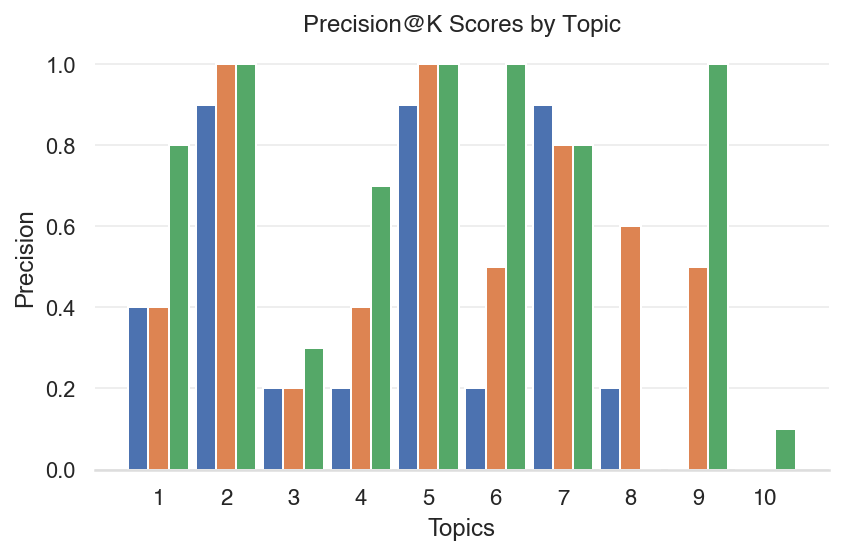

In [90]:
import matplotlib.pyplot as plt
import matplotlib as mpl

hfont = {'fontname':'Helvetica'}

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rect_acl_dlm = ax.bar(x - width, acl_diriciletlm_precision, width, label='ACL + Dirichilet')
# rect_acl_dlm_acl = ax.bar(x, acl_diriciletlm_acl_precision, width, label='ACL + Dirichilet + ACL')
#rect_w_conc_dlm = ax.bar(x + width, w_conclusion_diriciletlm_precision, width, label='w/Conc + Dirichlet')
rect_bm25_qbf = ax.bar(x, bm25_qbf_precision, width, label='Bm25 + ACL')
#rect_svm_dlm = ax.bar(x + width, svm_diricilet_precision, width, label='SVM')
rect_noun_dlm = ax.bar(x + width, premise_conc_dml_noun_boosting_acl_precision, width, label='DirichletLM + Noun Chunking + ACL')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision')
ax.set_xlabel('Topics')
ax.set_title('Precision@K Scores by Topic', **hfont)
ax.set_xticks(x, labels, **hfont)



#ax.bar_label(rect_acl_dlm, padding=3)
#ax.bar_label(rect_acl_dlm_acl, padding=3)
#ax.bar_label(rect_w_conc_dlm, padding=3)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

fig.tight_layout()

plt.savefig('plots/scores_approches.jpg')

plt.show()


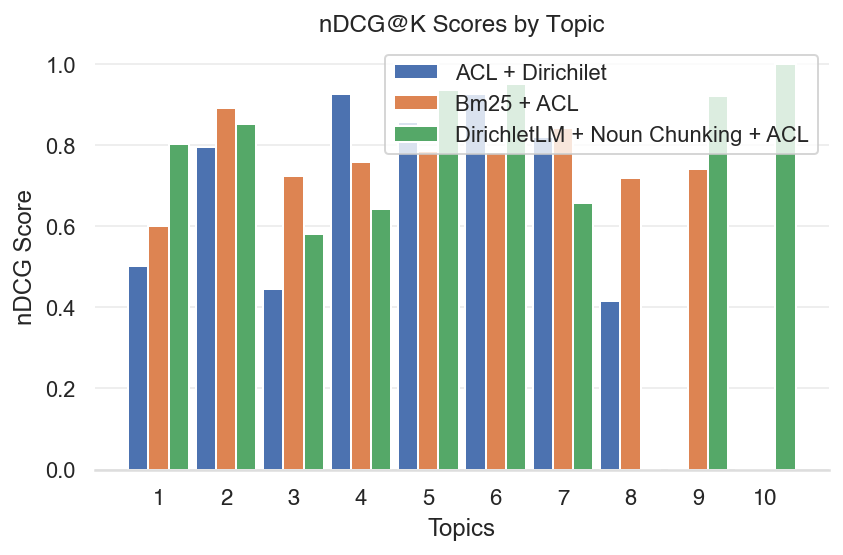

In [83]:
import matplotlib.pyplot as plt
import matplotlib as mpl

hfont = {'fontname':'Helvetica'}

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rect_acl_dlm = ax.bar(x - width, acl_diriciletlm_ndcg, width, label='ACL + Dirichilet')
#rect_acl_dlm_acl = ax.bar(x, acl_diriciletlm_acl_ndcg, width, label='ACL + Dirichilet + ACL')
#rect_w_conc_dlm = ax.bar(x + width, w_conclusion_diriciletlm_precision, width, label='w/Conc + Dirichlet')
rect_bm25_qbf = ax.bar(x, bm25_qbf_ndcg, width, label='Bm25 + ACL')
#rect_svm_dlm = ax.bar(x + width, svm_diricilet_precision, width, label='SVM')
rect_noun_dlm = ax.bar(x + width, premise_conc_dml_noun_boosting_acl_ndcg, width, label='DirichletLM + Noun Chunking + ACL')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('nDCG Score')
ax.set_xlabel('Topics')
ax.set_title('nDCG@K Scores by Topic', **hfont)
ax.set_xticks(x, labels, **hfont)
ax.legend()

#ax.bar_label(rect_acl_dlm, padding=3)
#ax.bar_label(rect_acl_dlm_acl, padding=3)
#ax.bar_label(rect_w_conc_dlm, padding=3)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

fig.tight_layout()

plt.savefig('plots/scores_approches.jpg')

plt.show()


In [25]:
df_precision = pd.DataFrame(index=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [26]:
df_precision['acl_diriciletlm_precision'] =  acl_diriciletlm_precision
df_precision['acl_diriciletlm_acl_precision'] =  acl_diriciletlm_acl_precision
df_precision['w_conclusion'] =  w_conclusion_diriciletlm_precision
df_precision['svm_diricilet_precision'] =  svm_diricilet_precision

In [27]:
df_precision

acl_diriciletlm_precision  acl_diriciletlm_acl_precision  w_conclusion  \
1                         0.4                            0.2           0.4   
2                         0.9                            0.8           1.0   
3                         0.2                            0.1           0.2   
4                         0.2                            0.2           0.3   
5                         0.9                            1.0           1.0   
6                         0.2                            0.2           0.2   
7                         0.9                            1.0           0.6   
8                         0.2                            0.2           0.6   
9                         0.0                            0.5           0.5   
10                        0.0                            0.0           0.0   

    svm_diricilet_precision  
1                       0.4  
2                       0.8  
3                       0.1  
4                       0.2  
5                       0.8  
6                       0.2  
7                       0.8  
8                       0.1  
9                       0.2  
10                      0.0

In [20]:
acl_diriciletlm_precision, acl_diriciletlm_acl_ndcg = eval_scoring("data/evaluation/porthos_acl_lm_basic - porthos_acl_lm_basic.csv")
acl_diriciletlm_acl_precision, acl_diriciletlm_acl__ndcg = eval_scoring("data/evaluation/porthos_acl_lm_basic_acl - porthos_acl_lm_basic_acl.csv")
w_conclusion_diriciletlm_precision, w_conclusion_diriciletlm_ndcg = eval_scoring("data/evaluation/porthos_lm_analyzed_w_conclusion - porthos_lm_analyzed_w_conclusion.csv")
svm_diricilet_precision, svm_diricilet_ndcg = eval_scoring("data/evaluation/porthos_svm_lm_basic - porthos_svm_lm_basic.csv")

w_conclusion
0           0.4
1           1.0
2           0.2
3           0.3
4           1.0
5           0.2
6           0.6
7           0.6
8           0.5
9           0.0

In [24]:
df_precision

w_conclusion  acl_diriciletlm_precision  acl_diriciletlm_acl_precision  \
0           0.4                        0.4                            0.2   
1           1.0                        0.9                            0.8   
2           0.2                        0.2                            0.1   
3           0.3                        0.2                            0.2   
4           1.0                        0.9                            1.0   
5           0.2                        0.2                            0.2   
6           0.6                        0.9                            1.0   
7           0.6                        0.2                            0.2   
8           0.5                        0.0                            0.5   
9           0.0                        0.0                            0.0   

   svm_diricilet_precision  
0                      0.4  
1                      0.8  
2                      0.1  
3                      0.2  
4                      0.8  
5                      0.2  
6                      0.8  
7                      0.1  
8                      0.2  
9                      0.0

In [31]:
topics = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [32]:
df_precision['topic'] = topics

In [36]:
df_precision

acl_diriciletlm_precision  acl_diriciletlm_acl_precision  w_conclusion  \
1                         0.4                            0.2           0.4   
2                         0.9                            0.8           1.0   
3                         0.2                            0.1           0.2   
4                         0.2                            0.2           0.3   
5                         0.9                            1.0           1.0   
6                         0.2                            0.2           0.2   
7                         0.9                            1.0           0.6   
8                         0.2                            0.2           0.6   
9                         0.0                            0.5           0.5   
10                        0.0                            0.0           0.0   

    svm_diricilet_precision topic  
1                       0.4     1  
2                       0.8     2  
3                       0.1     3  
4                       0.2     4  
5                       0.8     5  
6                       0.2     6  
7                       0.8     7  
8                       0.1     8  
9                       0.2     9  
10                      0.0    10

### Preprocessed with ACL DirichletLM and Arguments classified with ACL

In [ ]:
colnames = ['relevance', 'output']
df = pd.read_csv('data/evaluation/porthos_acl_lm_basic_acl - porthos_acl_lm_basic_acl.csv', usecols=colnames)
df = df.reset_index().drop(['index'], axis=1)
relevance = df['relevance'].tolist()
print(f'Precision: {calc_precision_score(relevance, n_topics=10)}')
print(f'NDCG: {calc_ndcg_score(relevance, n_topics=10)}')

### DirichletLM + Analyzed + Boolean Query with Conclusion

In [8]:
colnames = ['relevance', 'output']
df = pd.read_csv('data/evaluation/porthos_lm_analyzed_w_conclusion - porthos_lm_analyzed_w_conclusion.csv', usecols=colnames)
df = df.reset_index().drop(['index'], axis=1)
relevance = df['relevance'].tolist()
print(f'Precision: {precision(clean_list(relevance))}')
print(f'NDCG: {calc_ndcg_score(relevance, n_topics=10)}')

Precision: 0.48
[[2 2 1 1 0 0 0 0 0 0]] [[0 0 0 1 0 0 0 2 1 2]]
[0.5049368134567783]
[[3 3 3 2 2 2 1 1 1 1]] [[1 1 1 3 1 2 2 3 2 3]]
[0.5049368134567783, 0.7829497856538262]
[[1 1 0 0 0 0 0 0 0 0]] [[0 0 0 1 0 0 0 1 0 0]]
[0.5049368134567783, 0.7829497856538262, 0.44646766332803833]
[[2 2 1 0 0 0 0 0 0 0]] [[2 0 1 0 0 0 0 2 0 0]]
[0.5049368134567783, 0.7829497856538262, 0.44646766332803833, 0.7496963899501926]
[[3 3 2 2 2 2 1 1 1 1]] [[2 3 1 2 2 2 3 1 1 1]]
[0.5049368134567783, 0.7829497856538262, 0.44646766332803833, 0.7496963899501926, 0.90476236335715]
[[1 1 0 0 0 0 0 0 0 0]] [[0 0 0 0 0 0 1 1 0 0]]
[0.5049368134567783, 0.7829497856538262, 0.44646766332803833, 0.7496963899501926, 0.90476236335715, 0.44646766332803833]
[[1 1 1 1 1 1 0 0 0 0]] [[1 0 0 0 0 1 1 1 1 1]]
[0.5049368134567783, 0.7829497856538262, 0.44646766332803833, 0.7496963899501926, 0.90476236335715, 0.44646766332803833, 0.708225354913938]
[[3 3 3 2 2 1 0 0 0 0]] [[0 2 0 2 0 1 3 0 3 3]]
[0.5049368134567783, 0.7829497856

### Query based Filtering with ACL Classifier

In [29]:
colnames = ['relevance', 'output']
df = pd.read_csv('data/evaluation/eval_nsp_qbf_last_year_topics - eval_nsp_qbf_last_year_topics.csv', usecols=colnames)

In [57]:
df = df.reset_index().drop(['index'], axis=1)

In [58]:
relevance_qbf = df['relevance'].tolist()

In [59]:
precision(clean_list(relevance_qbf))

0.54

In [60]:
calc_ndcg_score(relevance_qbf, n_topics=10)

0.6846532894299153

### Plot relevance bockets compared

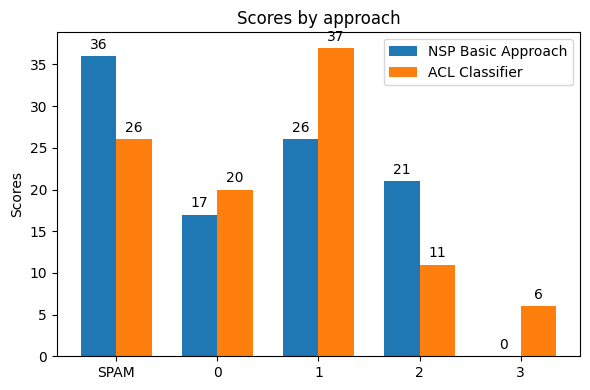

In [94]:
import matplotlib.pyplot as plt
import matplotlib.ticker
labels = ['SPAM', '0', '1', '2', '3']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_dpi(100)
rects1 = ax.bar(x - width/2, create_relevance_buckets(relevance_nsp), width, label='NSP Basic Approach')
rects2 = ax.bar(x + width/2, create_relevance_buckets(clean_list(relevance_qbf)), width, label='ACL Classifier')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by approach')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
labels = ['SPAM', '0', '1', '2', '3']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rect_nils = ax.bar(x - width, create_relevance_buckets(clean_list(relevance_nils)), width, label='Nils')
rect_istvan = ax.bar(x, create_relevance_buckets(clean_list(relevance_istvan)), width, label='Istvan')
rect_pia = ax.bar(x + width, create_relevance_buckets(clean_list(relevance_pia)), width, label='Pia')
rects_qbf = ax.bar(x + width/4, create_relevance_buckets(clean_list(relevance_qbf)), width, label='ACL Classifier')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by reviewer')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rect_nils, padding=3)
ax.bar_label(rect_istvan, padding=3)
ax.bar_label(rect_pia, padding=3)

fig.tight_layout()

plt.savefig('plots/scores_by_reviewer.jpg')

plt.show()


## NDCG Score

In [274]:
start = 1
RELEVANCE_EVAL = ['R_N', 'R_I', 'R_P']
#RELEVANCE_EVAL = ['R_N']
colnames = ['topic', 'R_N', 'R_I', 'R_P']
df_eval = pd.DataFrame(columns=colnames)
for j in range(10):
    for i in RELEVANCE_EVAL:
        df_eval.at[j+1, 'topic'] = df['sent_pair'].iloc[start-1][3:]
        relevance_list =  [int(s) if int(s) >= 0 else 0 for s in df[i][start:start + 10].tolist()]
        scores = np.asarray([relevance_list])
        true_relevance = np.asarray([sorted(relevance_list,reverse=True)])
        ndgc = ndcg_score(true_relevance, scores)
        df_eval.at[j+1, i] = ndgc

    start += 12
df_eval['ndcg'] = df_eval[['R_N', 'R_I', 'R_P']].mean(axis=1)
print(df_eval['ndcg'].mean())

0.6536534015931171


In [ ]:
df_eval

In [4]:
path_nsp_pair = "data/evaluation/eval_nsp_last_year_topics - eval_nsp_last_year_topics.csv"
path_sent_sim_pair = "data/evaluation/eval_sent_sim_last_year_topics - eval_sent_sim_last_year_topics.csv"

In [6]:
colnames = ['id', 'R_N', 'R_I', 'R_P', 'S_N', 'S_I', 'S_P', 'sent_pair']

In [7]:
df = pd.read_csv(path_nsp_pair, names=colnames).drop(['id'], axis=1)

In [8]:
df = df.iloc[2:]

In [11]:
df

R_N  R_I  R_P  S_N  S_I  S_P  \
0    NaN  NaN  NaN  NaN  NaN  NaN   
1      1    2    2    1    1    2   
2      1    2    1    1   -1    1   
3      0    1    0   -2   -2   -2   
4      0    2    0    0    0    0   
..   ...  ...  ...  ...  ...  ...   
595  NaN  NaN  NaN  NaN  NaN  NaN   
596  NaN  NaN  NaN  NaN  NaN  NaN   
597  NaN  NaN  NaN  NaN  NaN  NaN   
598  NaN  NaN  NaN  NaN  NaN  NaN   
599  NaN  NaN  NaN  NaN  NaN  NaN   

                                             sent_pair  
0              1. Do we need sex education in schools?  
1    What we need is open, honest, and frank discus...  
2    One, is that we should teach sex education in ...  
3    State Policies on Sex Education in Schools. In...  
4    should sex education be taught in schools ? In...  
..                                                 ...  
595  Also, there are plans set up(Water for the Poo...  
596  Cash is only a medium when cash contains value...  
597    Do we need deregulation? Do we need television?  
598        Do we need television? Do we need religion?  
599                                                NaN  

[600 rows x 7 columns]

In [10]:
df = df.reset_index().drop(['index'], axis=1)

In [305]:
RELEVANCE_EVAL = ['R_N', 'R_I', 'R_P']
colnames = ['topic', 'R_N', 'R_I', 'R_P']
def calc_ndcg_score(df: pd.DataFrame, relevance_names: list[str], colnames: list[str]) -> float:
    start = 1
    df_eval = pd.DataFrame(columns=colnames)
    for j in range(10):
        for i in relevance_names:
            df_eval.at[j+1, 'topic'] = df['sent_pair'].iloc[start-1][3:]
            relevance_list =  [int(s) if int(s) >= 0 else 0 for s in df[i][start:start + 10].tolist()]
            scores = np.asarray([relevance_list])
            true_relevance = np.asarray([sorted(relevance_list,reverse=True)])
            ndgc = ndcg_score(true_relevance, scores)
            df_eval.at[j+1, i] = ndgc

        start += 12
    df_eval['ndcg'] = df_eval[['R_N', 'R_I', 'R_P']].mean(axis=1)
    return df_eval['ndcg'].mean()

0.5510534133824377


In [19]:
def calc_ndcg_score(df: pd.DataFrame, relevance_columns: list[str], colnames: list[str]) -> float:
    start = 1
    df_eval = pd.DataFrame(columns=colnames)
    for j in range(10):
        for i in relevance_columns:
            df_eval.at[j+1, 'topic'] = df['sent_pair'].iloc[start-1][3:]
            relevance_list =  [int(s) if int(s) >= 0 else 0 for s in df[i][start:start + 10].tolist()]
            scores = np.asarray([relevance_list])
            true_relevance = np.asarray([sorted(relevance_list,reverse=True)])
            ndgc = ndcg_score(true_relevance, scores)
            df_eval.at[j+1, i] = ndgc

        start += 12
    df_eval['ndcg'] = df_eval[relevance_columns].mean(axis=1)
    return df_eval['ndcg'].mean()

In [26]:
path_nsp_pair = "data/evaluation/eval_nsp_last_year_topics - eval_nsp_last_year_topics.csv"
path_sent_sim_pair = "data/evaluation/eval_sent_sim_last_year_topics - eval_sent_sim_last_year_topics.csv"

In [27]:
df = pd.read_csv(path_sent_sim_pair, names=colnames)

### Evaluate Next Sentence Prediction

In [17]:
colnames = ['id', 'R_N', 'R_I', 'R_P', 'S_N', 'S_I', 'S_P', 'sent_pair']
df = pd.read_csv(path_nsp_pair, names=colnames).drop(['id'], axis=1)
df = df.iloc[2:]
df = df.reset_index().drop(['index'], axis=1)

Calculate Relevance Score with nDCG@k

In [20]:
RELEVANCE_EVAL = ['R_N', 'R_I', 'R_P']
eval_colnames = ['topic', 'R_N', 'R_I', 'R_P']
calc_ndcg_score(df=df, relevance_columns=RELEVANCE_EVAL, colnames=eval_colnames)

0.6536534015931171

Calculate Sentence Pair Score with nDCG@k

In [348]:
RELEVANCE_EVAL = ['S_N', 'S_I', 'S_P']
eval_colnames = ['topic', 'S_N', 'S_I', 'S_P']
calc_ndcg_score(df=df, relevance_columns=RELEVANCE_EVAL, colnames=eval_colnames)

0.6744424926034294

### Evaluate Sentence Similartiy

In [21]:
colnames = ['id', 'R_N', 'R_I', 'R_P', 'S_N', 'S_I', 'S_P', 'sent_pair']
df = pd.read_csv(path_sent_sim_pair, names=colnames).drop(['id'], axis=1)
df = df.iloc[2:]
df = df.reset_index().drop(['index'], axis=1)

Calculate Relevance Score with nDCG@k

In [22]:
RELEVANCE_EVAL = ['R_N', 'R_I', 'R_P']
eval_colnames = ['topic', 'R_N', 'R_I', 'R_P']
calc_ndcg_score(df=df, relevance_columns=RELEVANCE_EVAL, colnames=eval_colnames)

0.5510534133824377

Calculate Sentence Pair Score with nDCG@k

In [353]:
RELEVANCE_EVAL = ['S_N', 'S_I', 'S_P']
eval_colnames = ['topic', 'S_N', 'S_I', 'S_P']
calc_ndcg_score(df=df, relevance_columns=RELEVANCE_EVAL, colnames=eval_colnames)

0.6133791994583644